In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler

import seaborn as sns

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")

In [2]:
# Dataset con el cual entrenaremos nuestro modelo

#Rafael Ballester-Ripoll, Enrique G. Paredes, Renato Pajarola.
#Sobol Tensor Trains for Global Sensitivity Analysis.
#In arXiv Computer Science / Numerical Analysis e-prints, 2017
#(https://128.84.21.199/abs/1712.00233).

#Cedric Nugteren and Valeriu Codreanu. CLTune: A Generic Auto-Tuner for OpenCL Kernels.
#In: MCSoC: 9th International Symposium on Embedded Multicore/Many-core Systems-on-Chip. IEEE, 2015
#(http://ieeexplore.ieee.org/document/7328205/)

raw_data_url = 'https://raw.githubusercontent.com/daneelsan/INF648-Project/main/dataset/sgemm_product.csv'
raw_data = pd.read_csv(raw_data_url);
raw_data.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


In [3]:
# Valores estadísticos para cada columna
raw_data.describe()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,80.415364,80.415364,25.513113,13.935894,13.935894,17.371126,17.371126,5.000000,2.448609,2.448609,0.500000,0.500000,0.500000,0.500000,217.647852,217.579536,217.532756,217.527669
std,42.469220,42.469220,7.855619,7.873662,7.873662,9.389418,9.389418,3.000006,1.953759,1.953759,0.500001,0.500001,0.500001,0.500001,369.012422,368.677309,368.655118,368.677413
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.290000,13.250000,13.360000,13.370000
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.660000,40.710000,40.660000,40.640000
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,5.000000,2.000000,2.000000,0.500000,0.500000,0.500000,0.500000,69.825000,69.930000,69.790000,69.820000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,228.530000,228.310000,228.320000,228.320000
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3339.630000,3375.420000,3397.080000,3361.710000


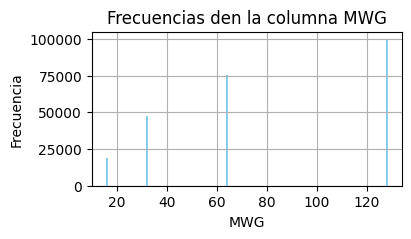

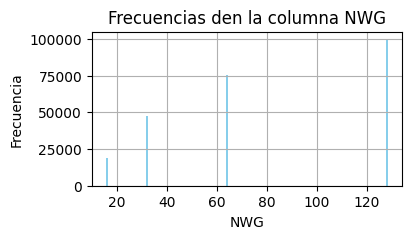

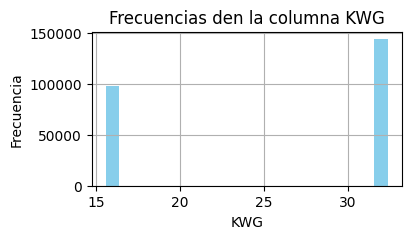

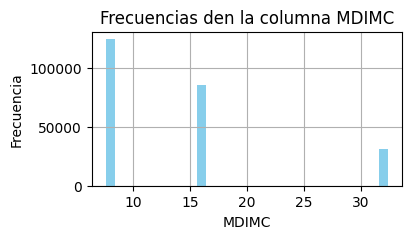

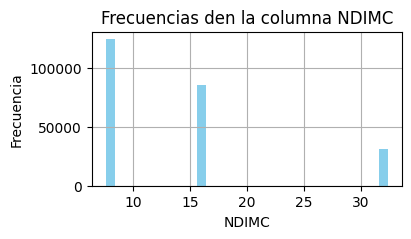

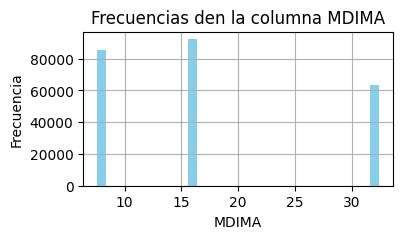

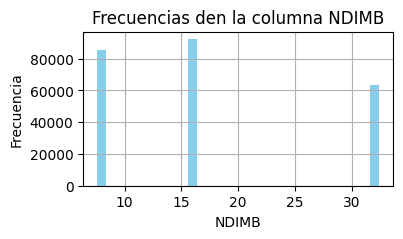

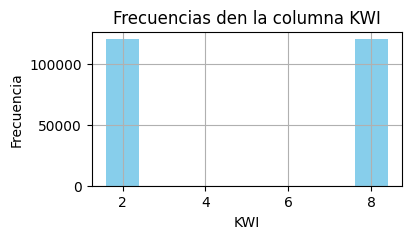

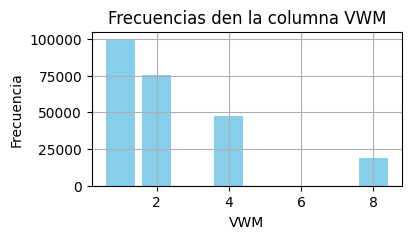

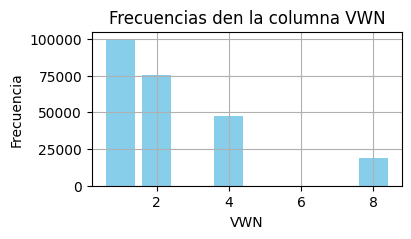

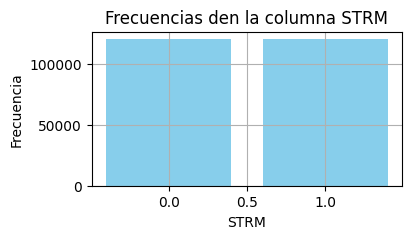

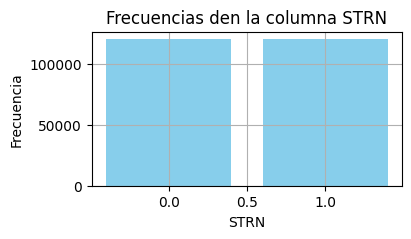

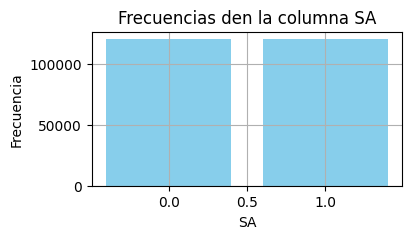

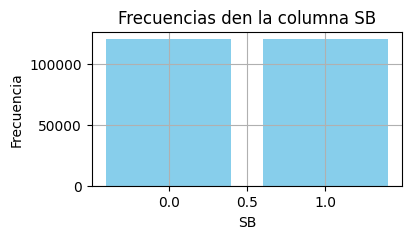

In [4]:
for n in range(14):
  # Seleccionar la primera columna para la visualización de frecuencias
  columna = raw_data.columns[n]

  # Calcular las frecuencias de valores en la columna seleccionada
  frecuencias = raw_data[columna].value_counts().sort_index()

  # Configurar el gráfico
  plt.figure(figsize=(4, 2))
  plt.bar(frecuencias.index, frecuencias.values, color='skyblue')
  plt.xlabel(columna)
  plt.ylabel('Frecuencia')
  plt.title(f'Frecuencias den la columna {columna}')
  plt.grid(True)
  # Establecer los límites y el paso del eje X
  #step = 4  # Multiplos de 4 en el eje X
  #plt.xticks(np.arange(min(frecuencias.index), max(frecuencias.index)+1, step))
  plt.show()

# Preprocesamiento de datos

In [5]:
# Trabajemos con una copia del dataset
data = raw_data;

# Las últimas cuatro columnas son las variables objetivo (Run1 (ms), Run2 (ms), Run3 (ms), Run4 (ms))
# Crear una variable objetivo única como el logaritmo del promedio de estos tiempos de ejecución
data['average_run'] = data[['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)']].mean(axis=1)
data['log_average_run'] = np.log(data['average_run'])

# Eliminar las columnas de tiempos de ejecución originales y la columna 'average_run'
data = data.drop(columns=['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)', 'average_run'])

# Data de entrenamiento y prueba

In [6]:
# Características y objetivo
X = data.drop(columns=['log_average_run'])
y = data['log_average_run']

X[:5]

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0


In [18]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configurar el modelo AdaBoostRegressor
param_grid = {
    'n_estimators': [50, 100],  # Número de estimadores base (árboles de decisión)
    'learning_rate': [0.01, 0.1],  # Tasa de aprendizaje del modelo
    'loss': ['linear', 'square', 'exponential']  # Función de pérdida
}

# Configurar el modelo AdaBoostRegressor
modelAdaBoost = AdaBoostRegressor(random_state=42)

In [19]:
# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=modelAdaBoost, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=1)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Obtener el mejor modelo del grid search
best_adaboost = grid_search.best_estimator_

# Predicciones en el conjunto de prueba
y_pred = best_adaboost.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 100}


In [20]:
# Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")

# Calcular el coeficiente de determinación R^2
r2 = r2_score(y_test, y_pred)
print(f"Coeficiente de determinación R^2: {r2}")

Error Cuadrático Medio (MSE): 0.4097211340865908
Coeficiente de determinación R^2: 0.6750628225146083


In [21]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configurar el modelo BaggingRegressor con un árbol de decisión base
param_grid = {
    'n_estimators': [50, 100],  # Número de estimadores en el ensamble
    'max_samples': [0.5, 0.7],  # Proporción de muestras a extraer para cada estimador
    'max_features': [0.5, 0.7],  # Proporción de características a extraer para cada estimador
    'bootstrap': [True, False],  # Si se debe realizar bootstrap en las muestras
    'random_state': [42]
}

# Configurar el modelo BaggingRegressor
base_estimator = BaggingRegressor(random_state=42)
modelBagging = BaggingRegressor(base_estimator=base_estimator)

In [22]:
# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=modelBagging, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=1)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Obtener el mejor modelo del grid search
best_bagging = grid_search.best_estimator_

# Predicciones en el conjunto de prueba
y_pred = best_bagging.predict(X_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


KeyboardInterrupt: 

In [ ]:
# Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")

# Calcular el coeficiente de determinación R^2
r2 = r2_score(y_test, y_pred)
print(f"Coeficiente de determinación R^2: {r2}")

# Reducción de dimensionalidad

## 1. Selección de características por filtrado

In [ ]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import chi2, mutual_info_classif

X.shape

(241600, 14)

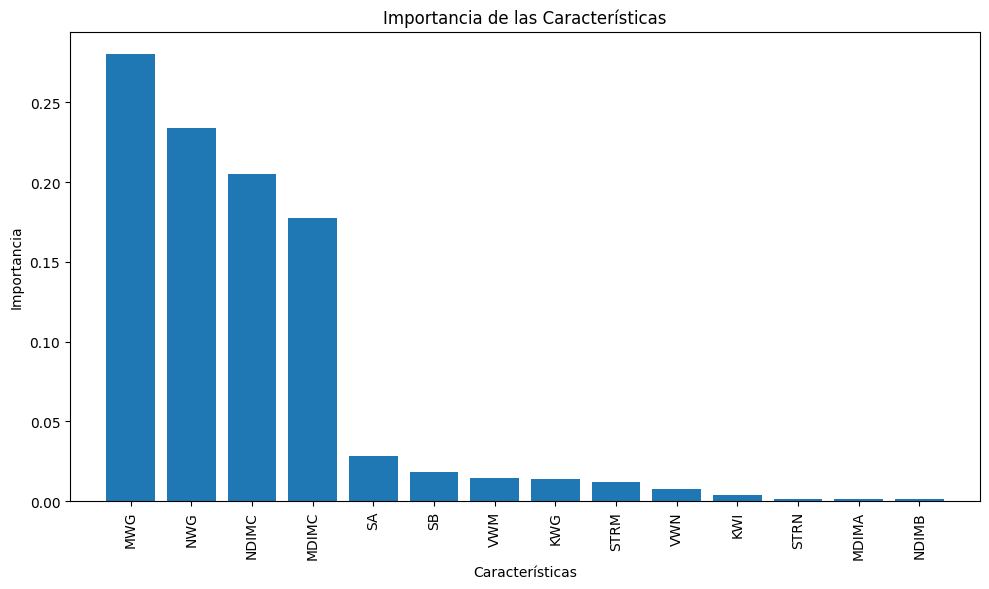

In [ ]:
# Entrenar un modelo de Random Forest para obtener la importancia de características
model = RandomForestRegressor()
model.fit(X, y)

# Obtener la importancia de las características
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]  # Ordenar los índices de mayor a menor importancia

# Plotear la importancia de las características
plt.figure(figsize=(10, 6))
plt.title("Importancia de las Características")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

# Entrenar modelo de RandomForest

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Inicializar el modelo de Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coeficiente de Determinación (R²): {r2}")

Error Cuadrático Medio (MSE): 0.0007723076066049279
Coeficiente de Determinación (R²): 0.999387506689397
